# Mini Project 1

# Hepatitis dataset
http://archive.ics.uci.edu/ml/datasets/Hepatitis

In [1]:
import pandas as pd
import numpy as np

#the output of plotting commands is displayed inline within frontends
%matplotlib inline                                  
import matplotlib.pyplot as plt

#it is important to set the seed for reproducibility as it initializes the random number generator
np.random.seed(789)

## Data processing


In [2]:
df = pd.read_csv("/content/hepatitis.csv")
df.drop_duplicates(subset=None, keep='first', inplace=True) # remove duplicated rows
df = df[~df.eq('?').any(1)] # remove missing data 
df = df.reset_index(drop=True)
df

,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
0,2,34,1,2,2,2,2,2,2,2,2,2,2,2,0.90,95,28,4.0,75,1
1,2,39,1,1,1,2,2,2,1,1,2,2,2,2,1.30,78,30,4.4,85,1
2,2,32,1,2,1,1,2,2,2,1,2,1,2,2,1.00,59,249,3.7,54,1
3,2,41,1,2,1,1,2,2,2,1,2,2,2,2,0.90,81,60,3.9,52,1
4,2,30,1,2,2,1,2,2,2,1,2,2,2,2,2.20,57,144,4.9,78,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2,45,1,2,1,2,2,2,2,2,2,2,2,2,1.30,85,44,4.2,85,2
76,1,49,1,1,2,1,1,2,2,2,1,1,2,2,1.40,85,70,3.5,35,2
77,2,31,1,1,2,1,2,2,2,2,2,2,2,2,1.20,75,173,4.2,54,2
78,2,53,2,1,2,1,2,2,2,2,1,1,2,1,1.50,81,19,4.1,48,2


1 SEX
2 STEROID
3 ANTIVIRALS
4 FATIGUE
5 MALAISE
6 ANOREXIA
7 LIVER_BIG
8 LIVER_FIRM
9 SPLEEN_PALPABLE
10 SPIDERS
11 ASCITES
12 VARICES
13 HISTOLOGY


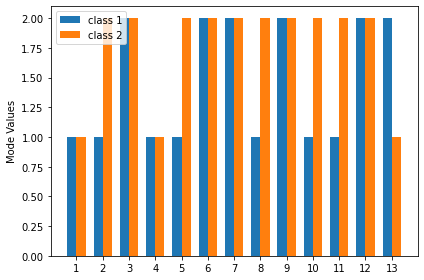

In [3]:
mode = df.drop(columns=["AGE","BILIRUBIN",	"ALK_PHOSPHATE",	"SGOT",	"ALBUMIN",	"PROTIME"]).groupby(by=["Class"]).agg(lambda x:x.value_counts().index[0])

#visualization of the data
label_names = list(mode.columns)
for i, label in enumerate(label_names):
    print(i + 1, label)
labels = [i for i in range(1, 14)]

class1_mode = mode.iloc[0].astype(int)
class2_mode = mode.iloc[1].astype(int)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, class1_mode, width, label='class 1')
rects2 = ax.bar(x + width/2, class2_mode, width, label='class 2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mode Values')
# ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

## KNN

In [4]:
x, y = df.loc[:,"AGE":"HISTOLOGY"], df.loc[:, "Class"]
# x.to_n
# normalized_df=(x-x.min())/(x.max()-x.min())

# reorder columns
cols = list(x.columns[1:13])
cols.append(str(x.columns[-1]))
cols.append(str(x.columns[0]))
cols.extend(list(x.columns[13:-1]))
x = x[cols]
x[x.columns[1:14]] = x[x.columns[1:14]].astype(int)
x[x.columns[14:]] = x[x.columns[14:]].astype(float)
print(x.dtypes)  
normalized_x=(x-x.min())/(x.max()-x.min())                                          #min-max normalization
# normalized_x

#print the feature shape and classes of dataset 
(N,D), C = x.shape, df["Class"].unique().size
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

train_num = int(N * 0.6)
val_num = int(N * 0.8)
inds = np.random.permutation(N)                                                     #generates an indices array from 0 to N-1 and permutes it 

#split the dataset into train, validation and test
x_train, y_train = normalized_x.loc[inds[:train_num],], y.loc[inds[:train_num],].to_numpy(dtype=np.int16).flatten()
x_val, y_val = normalized_x.loc[inds[train_num:val_num],], y.loc[inds[train_num:val_num],].to_numpy(dtype=np.int16).flatten()
x_test, y_test = normalized_x.loc[inds[val_num:],], y.loc[inds[val_num:],].to_numpy(dtype=np.int16).flatten()


SEX                  int64
STEROID              int64
ANTIVIRALS           int64
FATIGUE              int64
MALAISE              int64
ANOREXIA             int64
LIVER_BIG            int64
LIVER_FIRM           int64
SPLEEN_PALPABLE      int64
SPIDERS              int64
ASCITES              int64
VARICES              int64
HISTOLOGY            int64
AGE                  int64
BILIRUBIN          float64
ALK_PHOSPHATE      float64
SGOT               float64
ALBUMIN            float64
PROTIME            float64
dtype: object
instances (N) 	 80 
 features (D) 	 19 
 classes (C) 	 2


In [5]:
''' 
Using hamming distance:
By looking at the result from validation set, it doesn
'''
# define the metric we will use to measure similarity
# if the input shapes are [1,N1,F] and [N2,1,F] then output shape is [N2,N1]
# as numpy supports broadcasting with arithmetic operations
# for more on numpy broadcasting refer to: https://numpy.org/doc/stable/user/basics.broadcasting.html
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2) ** 2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)
def hamming(x1, x2):
    arr = np.sum((x1 - x2), axis=-1)
    arr[arr != 0] = 1
    return arr

class KNN:

    def __init__(self, K=1, dist_fn=euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return

    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = df["Class"].unique().size
        return self

    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        # calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        continous_dist = manhattan(self.x[None, :, 13:], x_test[:, None, 13:])
        categorical_dist = hamming(self.x[None, :, :13], x_test[:, None, :13])
        # nomalize and add the result
        distances = continous_dist / (np.amax(continous_dist) - np.amin(continous_dist)) + categorical_dist
        # ith-row of knns stores the indices of k closest training samples to the ith-test sample
        knns = np.zeros((num_test, self.K), dtype=int)
        # ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i, :] = np.argsort(distances[i])[:self.K]
            # counts the number of instances of each class in the K-closest training samples
            count_arr = np.bincount(self.y[knns[i, :]], minlength=3)
            y_prob[i, :] = [count_arr[1], count_arr[2]]
            # y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        # simply divide by K to get a probability distribution
        y_prob /= self.K
        return y_prob, knns

In [6]:
# define the metric we will use to measure similarity
# if the input shapes are [1,N1,F] and [N2,1,F] then output shape is [N2,N1]
# as numpy supports broadcasting with arithmetic operations
# for more on numpy broadcasting refer to: https://numpy.org/doc/stable/user/basics.broadcasting.html
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2) ** 2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)
def hamming(x1, x2):
    arr = np.sum((x1 - x2), axis=-1)
    arr[arr != 0] = 1
    return arr

class KNN:

    def __init__(self, K=1, dist_fn=manhattan):
        self.dist_fn = dist_fn
        self.K = K
        return

    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = df["Class"].unique().size
        return self

    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        # calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        distances = self.dist_fn(self.x[None, :, :], x_test[:, None, :])
        # ith-row of knns stores the indices of k closest training samples to the ith-test sample
        knns = np.zeros((num_test, self.K), dtype=int)
        # ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i, :] = np.argsort(distances[i])[:self.K]
            # counts the number of instances of each class in the K-closest training samples
            count_arr = np.bincount(self.y[knns[i, :]], minlength=3)
            y_prob[i, :] = [count_arr[1], count_arr[2]]
            # y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        # simply divide by K to get a probability distribution
        y_prob /= self.K
        return y_prob, knns

In [7]:
def evaluate_acc(K):
    model = KNN(K)
    y_prob, knns = model.fit(x_train.to_numpy(dtype=np.float), y_train).predict(x_test.to_numpy(dtype=np.float))
    y_pred = np.argmax(y_prob, axis=-1)
    for i in range(len(y_pred)):
        if y_pred[i] == 0:
            y_pred[i] = 1
        else:
            y_pred[i] = 2
    accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
    print(f'accuracy is {accuracy * 100:.1f}.')
    return accuracy

# #define a function for the MSE loss
# loss = lambda y, yh: np.mean((y-yh)**2)

# def mse(K):
#     model = KNN(K)
#     y_prob, knns = model.fit(x_train.to_numpy(dtype=np.float), y_train).predict(x_val.to_numpy(dtype=np.float))
#     y_pred = np.argmax(y_prob, axis=-1)
#     for i in range(len(y_pred)):
#         if y_pred[i] == 0:
#             y_pred[i] = 1
#         else:
#             y_pred[i] = 2
#     return loss(y_pred, y_val)

def evaluate_acc_val(K):
    model = KNN(K)
    y_prob, knns = model.fit(x_train.to_numpy(dtype=np.float), y_train).predict(x_val.to_numpy(dtype=np.float))
    y_pred = np.argmax(y_prob, axis=-1)
    for i in range(len(y_pred)):
        if y_pred[i] == 0:
            y_pred[i] = 1
        else:
            y_pred[i] = 2
    accuracy = np.sum(y_pred == y_val) / y_val.shape[0]
    # print(f'accuracy is {accuracy * 100:.1f}.')
    return accuracy


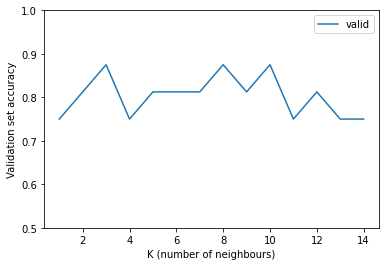

In [8]:
K_list = range(1,15)
err_valid = []
for K in K_list:
    err_valid.append(evaluate_acc_val(K))
    
plt.plot(K_list, err_valid, label='valid')

plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('Validation set accuracy')
plt.ylim(0.5, 1)
plt.show()

In [9]:
accuracy = evaluate_acc(3)

accuracy is 81.2.


## Decision Tree

In [10]:
x, y = df.loc[:,"AGE":"HISTOLOGY"], df.loc[:,["Class"]]                   #slices the first two columns or features from the data

#print the feature shape and classes of dataset 
(N,D), C = x.shape, df["Class"].unique().size
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

train_num = int(N * 0.6)
val_num = int(N * 0.8)
inds = np.random.permutation(N)                                                     #generates an indices array from 0 to N-1 and permutes it 

#split the dataset into train, validation and test
x_train, y_train = x.loc[inds[:train_num],], y.loc[inds[:train_num],].to_numpy(dtype=np.int16).flatten()
x_val, y_val = x.loc[inds[train_num:val_num],], y.loc[inds[train_num:val_num],].to_numpy(dtype=np.int16).flatten()
x_test, y_test = x.loc[inds[val_num:],], y.loc[inds[val_num:],].to_numpy(dtype=np.int16).flatten()

instances (N) 	 80 
 features (D) 	 19 
 classes (C) 	 2


In [11]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node 
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent 
            self.num_classes = parent.num_classes           #copies the num classes from the parent 
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built

In [12]:
def greedy_test(node, cost_fn):
    if type(node.data) != np.ndarray:
        node.data = node.data.to_numpy(dtype=np.float64)
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

In [13]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

In [14]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        self.cost_fn = cost_fn          #stores the cost function of the decision tree 
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        
    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty
    
    def predict(self, data_test):
        pass

In [15]:
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

In [16]:
def predict(self, data_test):
    data_test = data_test.to_numpy(dtype=np.float64)
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

In [17]:
def evaluate_acc(d):
    tree = DecisionTree(max_depth=d)
    probs_test = tree.fit(x_train, y_train).predict(x_test)
    y_pred = np.argmax(probs_test,1)
    accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
    print(f'accuracy is {accuracy*100:.1f}.')
    return accuracy

# #define a function for the MSE loss
# loss = lambda y, yh: np.mean((y-yh)**2)

# def mse(max_depth):
#     tree = DecisionTree(max_depth)
#     probs_test = tree.fit(x_train, y_train).predict(x_val)
#     y_pred = np.argmax(probs_test,1)
#     return loss(y_pred, y_val)

def evaluate_acc_val(d):
    tree = DecisionTree(max_depth=d)
    probs_test = tree.fit(x_train, y_train).predict(x_val)
    y_pred = np.argmax(probs_test,1)
    accuracy = np.sum(y_pred == y_val)/y_val.shape[0]
    # print(f'accuracy is {accuracy*100:.1f}.')
    return accuracy

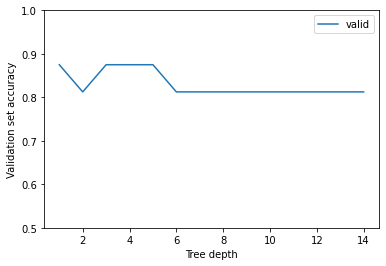

In [18]:
depth_list = [i for i in range(1,15)]
err_valid = []
for d in depth_list:
    err_valid.append(evaluate_acc_val(d))
    
plt.plot(depth_list, err_valid, label='valid')

plt.legend()
plt.xlabel('Tree depth')
plt.ylabel('Validation set accuracy')
plt.ylim(0.5, 1)
plt.show()

In [19]:
evaluate_acc(4)

accuracy is 93.8.


0.9375

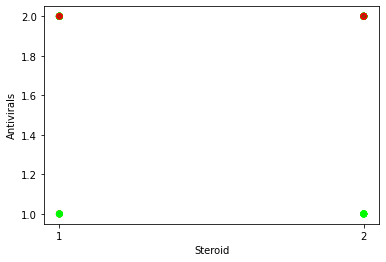

In [20]:
''' Decision boundary '''
y_train2 = np.copy(y_train)
for i in range(0, len(y_train2)):
    if y_train2[i] == 1:
        y_train2[i] = 0
    elif y_train2[i] == 2:
        y_train2[i] = 1
x_all = x
model = DecisionTree(max_depth=3)
y_train_prob = np.zeros((y_train.shape[0], 2))
y_train_prob[np.arange(y_train.shape[0]), y_train2] = 1
y_prob_all = model.fit(x_train, y_train).predict(x_all)
z = np.zeros((y_train_prob.shape[0],1), dtype=np.int16)
y_train_prob2 = np.append(y_train_prob, z, axis=1)
plt.scatter(x_train.iloc[:,2], x_train.iloc[:,3], c=y_train_prob2, marker='o', alpha=1)
plt.scatter(x_all.iloc[:,2], x_all.iloc[:,3], c=y_prob_all[:, [1, 2, 0]], marker='.', alpha=.01)
plt.ylabel('Antivirals')
plt.xlabel('Steroid')
plt.show()